In [27]:
import sys
from pathlib import Path

ROOT = Path.cwd().resolve()
if (ROOT / 'src').exists():
    sys.path.insert(0, str(ROOT))
elif (ROOT.parent / 'src').exists():
    sys.path.insert(0, str(ROOT.parent))


In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from surprise import Dataset, Reader, SVDpp, SVD, BaselineOnly, KNNBasic

from surprise.model_selection import cross_validate, train_test_split

from cluster_simulation import generate_mask_zipf_global, fill_ratings_clusters


In [29]:
U, I = 1000, 2000
pairs, uc, ic, A = generate_mask_zipf_global(
    U,
    I,
    density=0.063,
    alpha_user=0.9,
    alpha_item=0.9,
    seed=42,
    min_user_ratings=20,
    min_item_ratings=5,
    n_user_clusters=12,
    n_item_clusters=18,
    beta=1,
    return_clusters=True,
)

R_syn = fill_ratings_clusters(
    U=U,
    I=I,
    pairs=pairs,
    user_cluster=uc,
    item_cluster=ic,
    tau=np.array([-1.2, -0.4, 0.4, 1.2]),
    seed=42,
    mu=0,
    sigma_bu=0.5,
    sigma_bi=0.5,
    sigma_eps=0.4,
    gamma=0.4,
    A=A,
)

ratings_long = pd.DataFrame(R_syn).stack().reset_index()
ratings_long.columns = ['UserID', 'MovieID', 'Rating']
ratings_long.head()


,UserID,MovieID,Rating
0,0,0,3.0
1,0,40,2.0
2,0,65,3.0
3,0,92,5.0
4,0,94,3.0


In [30]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_long[['UserID', 'MovieID', 'Rating']], reader)
data


In [31]:
algo = SVDpp(n_epochs=5, random_state=42, verbose=True)
cv_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
pd.DataFrame(cv_results)


 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4


,test_rmse,test_mae,fit_time,test_time
0,0.695898,0.555681,13.088938,12.409742
1,0.701321,0.560630,12.879165,11.364336
2,0.694324,0.553808,13.005074,10.960946
3,0.690837,0.552224,12.844380,11.274310
4,0.693131,0.552953,12.934118,11.765177


In [32]:
algo = SVD(n_epochs=5, random_state=42, verbose=False)
cv_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
pd.DataFrame(cv_results)

,test_rmse,test_mae,fit_time,test_time
0,0.728235,0.585411,0.620549,0.390332
1,0.723721,0.582496,0.643789,0.227501
2,0.722622,0.580467,0.673176,0.207098
3,0.729851,0.587591,0.659887,0.386262
4,0.718401,0.577078,0.663122,0.214693


In [33]:

def evaluate_models_with_surprise(ratings_long, cv=3):
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(ratings_long[['UserID', 'MovieID', 'Rating']], reader)

    models = {
        'BaselineOnly': BaselineOnly(),
        'KNNBasic': KNNBasic(sim_options={'name': 'pearson_baseline', 'user_based': True}),
        'SVD': SVD(random_state=42),
        'SVDpp': SVDpp(random_state=42),
    }

    rows = []
    for name, algo in models.items():
        cv_results = cross_validate(algo, data, measures=['RMSE'], cv=cv, verbose=False)
        rows.append({'Model': name, 'RMSE': float(np.mean(cv_results['test_rmse']))})

    metrics_df = pd.DataFrame(rows)
    ref_rmse = metrics_df.loc[metrics_df['Model'] == 'BaselineOnly', 'RMSE'].iloc[0]
    metrics_df['Relative RMSE'] = metrics_df['RMSE'] / ref_rmse
    return metrics_df

mu_values = [-0.8, -0.4, 0.0, 0.4, 0.8]
rows = []

for mu in mu_values:
    R_syn = fill_ratings_clusters(
        U=U,
        I=I,
        pairs=pairs,
        user_cluster=uc,
        item_cluster=ic,
        tau=np.array([-1.2, -0.4, 0.4, 1.2]),
        seed=42,
        mu=mu,
        sigma_bu=0.5,
        sigma_bi=0.5,
        sigma_eps=0.4,
        gamma=0.4,
        A=A,
    )

    ratings_long = pd.DataFrame(R_syn).stack().reset_index()
    ratings_long.columns = ['UserID', 'MovieID', 'Rating']

    metrics_df = evaluate_models_with_surprise(ratings_long, cv=3)
    metrics_df['mu'] = mu
    rows.append(metrics_df)

mu_sweep_df = pd.concat(rows, ignore_index=True)
mu_sweep_df


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases u

,Model,RMSE,Relative RMSE,mu
0,BaselineOnly,0.682573,1.000000,-0.8
1,KNNBasic,0.805147,1.179576,-0.8
2,SVD,0.669806,0.981296,-0.8
3,SVDpp,0.648446,0.950002,-0.8
4,BaselineOnly,0.704075,1.000000,-0.4
5,KNNBasic,0.853845,1.212719,-0.4
6,SVD,0.690118,0.980178,-0.4
7,SVDpp,0.670504,0.952320,-0.4
8,BaselineOnly,0.702349,1.000000,0.0
9,KNNBasic,0.849067,1.208897,0.0


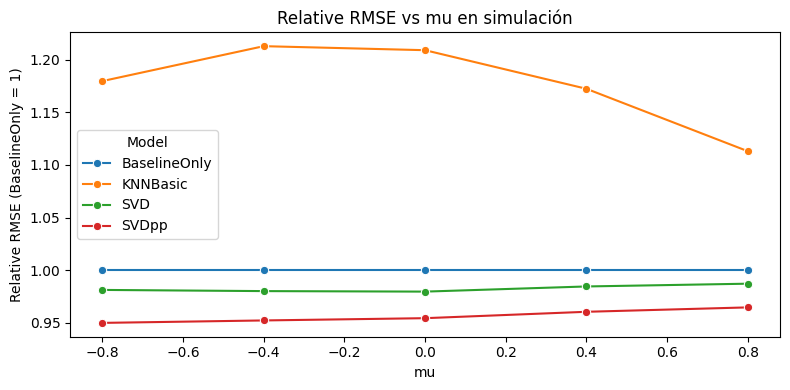

In [34]:
plt.figure(figsize=(8, 4))
sns.lineplot(data=mu_sweep_df, x='mu', y='Relative RMSE', hue='Model', marker='o')
plt.title('Relative RMSE vs mu en simulación')
plt.xlabel('mu')
plt.ylabel('Relative RMSE (BaselineOnly = 1)')
plt.tight_layout()
plt.show()


In [35]:
alpha_values = [0.3, 0.9, 1.5]
rows = []

for alpha_user in alpha_values:
    for alpha_item in alpha_values:
        pairs, uc, ic, A = generate_mask_zipf_global(
            U,
            I,
            density=0.063,
            alpha_user=alpha_user,
            alpha_item=alpha_item,
            seed=42,
            min_user_ratings=20,
            min_item_ratings=5,
            n_user_clusters=12,
            n_item_clusters=18,
            beta=1,
            return_clusters=True,
        )

        R_syn = fill_ratings_clusters(
            U=U,
            I=I,
            pairs=pairs,
            user_cluster=uc,
            item_cluster=ic,
            tau=np.array([-1.2, -0.4, 0.4, 1.2]),
            seed=42,
            mu=0,
            sigma_bu=0.5,
            sigma_bi=0.5,
            sigma_eps=0.4,
            gamma=0.4,
            A=A,
        )

        ratings_long = pd.DataFrame(R_syn).stack().reset_index()
        ratings_long.columns = ['UserID', 'MovieID', 'Rating']

        metrics_df = evaluate_models_with_surprise(ratings_long, cv=3)
        metrics_df['alpha_user'] = alpha_user
        metrics_df['alpha_item'] = alpha_item
        rows.append(metrics_df)

alpha_sweep_df = pd.concat(rows, ignore_index=True)
alpha_sweep_df


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases u

,Model,RMSE,Relative RMSE,alpha_user,alpha_item
0,BaselineOnly,0.696404,1.000000,0.3,0.3
1,KNNBasic,0.863179,1.239481,0.3,0.3
2,SVD,0.689319,0.989827,0.3,0.3
3,SVDpp,0.669448,0.961294,0.3,0.3
4,BaselineOnly,0.698837,1.000000,0.3,0.9
5,KNNBasic,0.846088,1.210709,0.3,0.9
6,SVD,0.689394,0.986487,0.3,0.9
7,SVDpp,0.661981,0.947260,0.3,0.9
8,BaselineOnly,0.707482,1.000000,0.3,1.5
9,KNNBasic,0.825875,1.167345,0.3,1.5


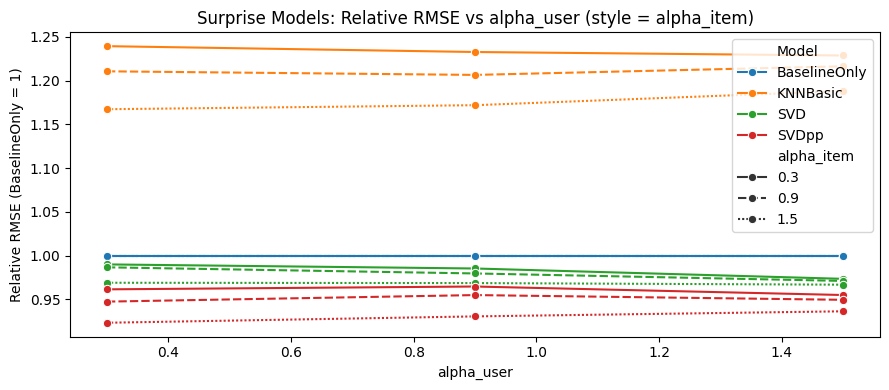

In [36]:
plt.figure(figsize=(9, 4))
sns.lineplot(
    data=alpha_sweep_df,
    x='alpha_user',
    y='Relative RMSE',
    hue='Model',
    style='alpha_item',
    marker='o',
)
plt.title('Surprise Models: Relative RMSE vs alpha_user (style = alpha_item)')
plt.xlabel('alpha_user')
plt.ylabel('Relative RMSE (BaselineOnly = 1)')
plt.tight_layout()
plt.show()


In [37]:
density_values = [0.01, 0.05, 0.1]
rows = []

for density in density_values:
    pairs, uc, ic, A = generate_mask_zipf_global(
        U,
        I,
        density=density,
        alpha_user=0.9,
        alpha_item=0.9,
        seed=42,
        min_user_ratings=20,
        min_item_ratings=5,
        n_user_clusters=12,
        n_item_clusters=18,
        beta=1,
        return_clusters=True,
    )

    R_syn = fill_ratings_clusters(
        U=U,
        I=I,
        pairs=pairs,
        user_cluster=uc,
        item_cluster=ic,
        tau=np.array([-1.2, -0.4, 0.4, 1.2]),
        seed=42,
        mu=0,
        sigma_bu=0.5,
        sigma_bi=0.5,
        sigma_eps=0.4,
        gamma=0.4,
        A=A,
    )

    ratings_long = pd.DataFrame(R_syn).stack().reset_index()
    ratings_long.columns = ['UserID', 'MovieID', 'Rating']

    metrics_df = evaluate_models_with_surprise(ratings_long, cv=3)
    metrics_df['density'] = density
    rows.append(metrics_df)

density_sweep_df = pd.concat(rows, ignore_index=True)
density_sweep_df


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases u

,Model,RMSE,Relative RMSE,density
0,BaselineOnly,0.794904,1.000000,0.01
1,KNNBasic,0.973687,1.224912,0.01
2,SVD,0.771630,0.970722,0.01
3,SVDpp,0.745474,0.937816,0.01
4,BaselineOnly,0.711197,1.000000,0.05
5,KNNBasic,0.860122,1.209401,0.05
6,SVD,0.697452,0.980673,0.05
7,SVDpp,0.678995,0.954722,0.05
8,BaselineOnly,0.691148,1.000000,0.10
9,KNNBasic,0.834464,1.207359,0.10


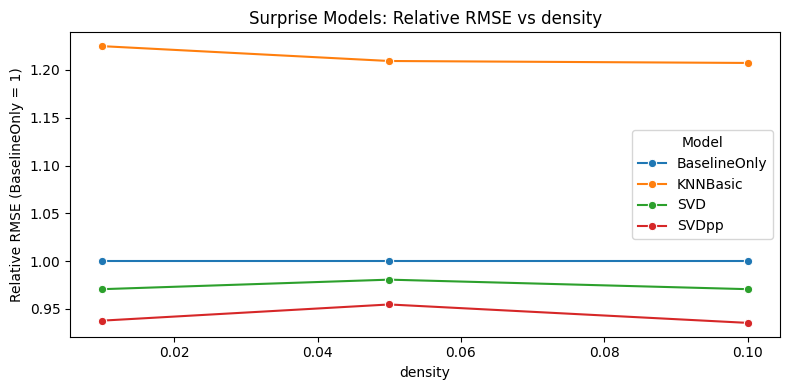

In [38]:
plt.figure(figsize=(8, 4))
sns.lineplot(data=density_sweep_df, x='density', y='Relative RMSE', hue='Model', marker='o')
plt.title('Surprise Models: Relative RMSE vs density')
plt.xlabel('density')
plt.ylabel('Relative RMSE (BaselineOnly = 1)')
plt.tight_layout()
plt.show()
